In [167]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['figure.dpi'] = 100

In [168]:
def generate_blue_to_red(N):
    # Create a colormap from red to blue
    cmap = plt.get_cmap('viridis')  # 'RdBu_r' is red to blue reversed
    colors = [mcolors.rgb2hex(cmap(i)[:3]) for i in np.linspace(0, 1, N)]
    return colors

In [169]:
def make_canonical_element(indices: list[int], n: int) -> np.array:
	""" 
		Construct the element of the canonical basis for a tensor of order len(indices), in dimension n. 
		indices are the indices of the canonical element
	"""
	x = np.zeros([n for _ in range(len(indices))])
	x[tuple(indices)] =1
	return x

In [170]:
def shuffle_product(left: list[int], right: list[int], n: int) -> list[np.array]:
	"""
		Perform the shuffle product between two signature basis

		left, right: "word", i.e. any element of the canonical basis of any tensor of any order, with dimension equal to n.
		n: dimension of the tensors
	"""
	
	if len(left) == 0:
		return make_canonical_element(right, n)
	elif len(right) == 0:
		return make_canonical_element(left, n)
	
	(begin_left, last_left) = left[:-1], left[-1]
	(begin_right, last_right) = right[:-1], right[-1]

	sub_left = shuffle_product(begin_left, right, n)
	sub_right = shuffle_product(left, begin_right, n)

	return (
		np.tensordot(sub_left, make_canonical_element([last_left], n), axes=0) +
		np.tensordot(sub_right, make_canonical_element([last_right], n), axes=0)
	)

In [171]:
def decompose_shuffle_result(shuffle_result: np.array) -> list[tuple[int]]:
	"""
		Given the result of some shuffle product, return the indices of the individual basis element that composes it
	"""
	return list(filter(
		lambda x: abs(shuffle_result[x]) > 1e-6,
		np.ndindex(shuffle_result.shape)
	))

In [172]:
def generate_brownian(t0, t1, n_divs, n_curves):
	return np.cumsum(np.concatenate(
		(np.zeros((n_curves, 1)), np.sqrt( (t1-t0) / n_divs) * npr.normal(0, 1, (n_curves, n_divs)) ),
		axis=1
	), axis=1)

In [173]:
def generate_ornstein_uhlenbeck(t0, t1, brownian_noises, x0, kappa, etha, theta):
	(n_curves, n_divs) = brownian_noises.shape
	brownian_diffs = (brownian_noises[:,1:] - brownian_noises[:,:-1])
	process = np.zeros( (n_curves, n_divs) )
	dt = (t1-t0)/(n_divs-1)
	process[:, 0] = x0
	for i in range(1, process.shape[1]):
		process[:, i] = process[:, i-1] + kappa * (theta - process[:, i-1]) * dt + etha*brownian_diffs[:, i-1]

	return process

In [174]:
def signature( x: np.ndarray, trunc: int ):
	"""
		Compute the truncated signature of x, where x is a sample of some stochastic process
		trunc is the maximum tensor order of the signature
	"""

	assert trunc >= 0, "trunc is the maximum tensor order, it cannot be negative"

	n_divs, dim = x.shape[1], x.shape[0]
	sig = [np.ones(n_divs), x]

	if trunc <= 2:
		return sig[:trunc+1]

	# Compute the next signature recursively
	for n in range(2, trunc+1):
		# numpy shape corresponding to the nth tensor of the signature
		shape_n = tuple([dim for _ in range(n)])
		sig_n = np.zeros( shape=shape_n+(n_divs,) )
		for index in np.ndindex(shape_n):
			integrals = np.zeros(n_divs)
			for i in range(n_divs-1):
				# Compute a stratonovich stochastic integral (taking the average instead of the left value)
				mean_val = (sig[n-1][(index[:-1] + (i,))] + sig[n-1][(index[:-1] + (i+1,))]) / 2
				integrals[i+1] = mean_val * (x[index[-1], i+1] - x[index[-1], i])
			sig_n[index] = integrals.cumsum()
		sig.append(sig_n)
	return sig

In [175]:
def signature_add(sig_left, sig_right):
	added_sigs = []
	for i in range(max(len(sig_left), len(sig_right))):
		if i >= len(sig_left):
			added_sigs.append( sig_right[i] )
		elif i >= len(sig_right):
			added_sigs.append( sig_left[i] )
		else:
			added_sigs.append( sig_left[i] + sig_right[i] )
	return added_sigs

In [176]:
def signature_prod(sig_left, sig_right):
	assert len(sig_left) >= 1 and len(sig_right) >= 1
	dim = sig_left[1].size
	sig_prod = [ np.zeros(tuple([dim for _ in range(n)])) for n in range(len(sig_left) + len(sig_right)) ]
	for i in range(len(sig_left)):
		for j in range(len(sig_right)):
			sig_prod[i+j] += np.tensordot(sig_left[i], sig_right[j], axes=0)
	return sig_prod

In [177]:
def compute_ornstein_uhlenbeck_signature(x0, kappa, etha, theta, exp_order=5):
	left = [ np.array(x0), np.array([kappa*theta, etha]) ]
	# compute exp(-kappa 1)
	right = [np.array(1.0)]
	for n in range(1,exp_order):
		right.append( make_canonical_element(tuple([0 for _ in range(n)]), 2) * np.power(-kappa, n))
	return signature_prod(left, right)

In [178]:
def compute_ornstein_uhlenbeck_signature_time(t, x0, kappa, etha, theta, exp_order=5):
	assert exp_order >= 2
	# the scalar part of the signature
	scalar_part = [theta + np.exp(-kappa*t)*(x0-theta), np.zeros(2)]
	# left hand side of the decomposition: exp(+kappa 1)
	expon = [np.array(1.0)]
	for n in range(1, exp_order):
		expon.append( make_canonical_element(tuple([0 for _ in range(n)]), 2) * np.power(kappa, n))
	# right hand side of the decomposition: etha 2
	rhs = [np.zeros( () ), np.array([0.0, etha*np.exp(-kappa*t)]) ]
	# final product
	return signature_add(scalar_part, signature_prod(expon, rhs))
	

In [179]:
def bracket(sig_left, sig_right):
	bracket_sum = 0.0
	for i in range(min(len(sig_left), len(sig_right))):
		bracket_sum += (sig_left[i] * sig_right[i]).sum()
	return bracket_sum

In [180]:
def bracket_with_process(cst_sig, process_sig):
	bracket_sum = np.zeros(process_sig[0].shape)
	for i in range(min(len(cst_sig), len(process_sig))):
		for index in np.ndindex(cst_sig[i].shape):
			bracket_sum += cst_sig[i][index] * process_sig[i][index]
	return bracket_sum

In [181]:
# Parameters
n = 50
max_sig_order = 8
x0 = 0.0
t0, t1 = 0.0, 1.0
kappa, theta, etha = 4.0, 0.25, 2.0
times = np.arange(start=0, stop=n+1) / n

# Generate a brownian noise and the corresponding ornstein process
brownians = generate_brownian(0, 1, n, 1)
brownian_sig = signature(np.array([times, brownians.flatten()]), max_sig_order)
ornsteins = generate_ornstein_uhlenbeck(0, 1, brownians, x0, kappa, etha, theta)

### Naïve approximation

Here, the signature of the process does not depend on time

In [186]:
true_uhlenbeck_sig = compute_ornstein_uhlenbeck_signature(x0, kappa, etha, theta, max_sig_order)
sig_ornsteins_1 = []
for sig_order in range(1, max_sig_order+1):
	# compute the ornstein process using the signature volatility model
	true_uhlenbeck_process_sig = bracket_with_process(true_uhlenbeck_sig[:sig_order+1], brownian_sig)

	sig_ornsteins_1.append(true_uhlenbeck_process_sig)

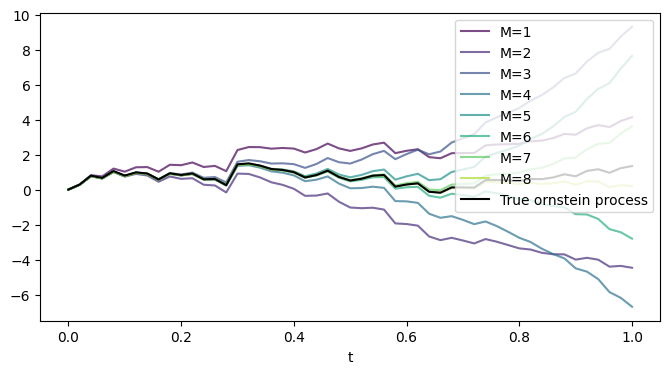

In [ ]:
cols = generate_blue_to_red(len(sig_ornsteins_1)+1)
for i in range(len(sig_ornsteins_1)):
	plt.plot(times, sig_ornsteins_1[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
plt.plot(times, ornsteins.transpose(), label="True ornstein process", color="black")
plt.legend()
plt.xlabel("t")
plt.savefig("outputs/ornstein_approx_naive.png")

### More stable approximation

This time, the signature depends on the time, and is computed such that the shuffle exponential has a positive coefficient, making it more stable

In [187]:
sig_ornsteins_2 = []
uhlenbeck_sig_time = []
for t in times:
	uhlenbeck_sig_time.append(
		compute_ornstein_uhlenbeck_signature_time(t, x0, kappa, etha, theta, max_sig_order)
	)

for sig_order in range(1, max_sig_order+1):
	# compute the ornstein process using the signature volatility model
	uhlenbeck_process_approx = np.zeros(times.shape[0])
	for i in range(times.shape[0]):
		brownian_sig_time = [b[..., i] for b in brownian_sig]
		uhlenbeck_process_approx[i] = bracket(uhlenbeck_sig_time[i][:sig_order+1], brownian_sig_time)
	sig_ornsteins_2.append(uhlenbeck_process_approx)

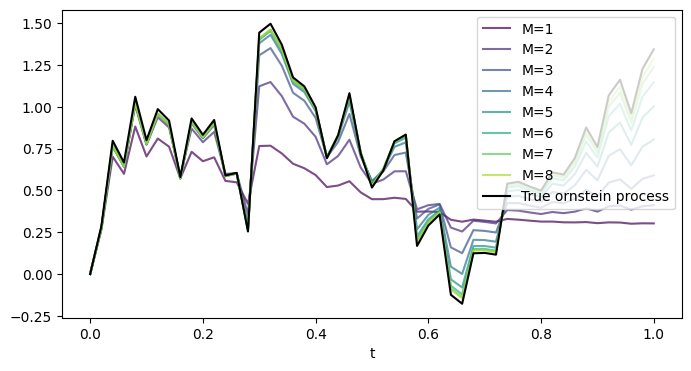

In [ ]:
cols = generate_blue_to_red(len(sig_ornsteins_2)+1)
for i in range(len(sig_ornsteins_2)):
	plt.plot(times, sig_ornsteins_2[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
plt.plot(times, ornsteins.transpose(), label="True ornstein process", color="black")
plt.legend()
plt.xlabel("t")
plt.savefig("outputs/ornstein_approx_stable.png")